In [1]:
import os
import pickle
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications import InceptionV3
from tensorflow.keras.utils import Sequence
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle(data, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)
        
data_saved_dir = r'D:\My Code\Classification\pickle_data'
train_val_data_path = os.path.join(data_saved_dir, 'D_preprocessed_data(256, 256).pkl')
train_images, train_labels, val_images, val_labels = load_pickle(train_val_data_path)

In [3]:
random_state = 42

train_indices = np.arange(len(train_images))
np.random.seed(random_state)
np.random.shuffle(train_indices)
train_images = train_images[train_indices]
train_labels = train_labels[train_indices]

val_indices = np.arange(len(val_images))
np.random.seed(random_state)
np.random.shuffle(val_indices)
val_images = val_images[val_indices]
val_labels = val_labels[val_indices]

In [4]:
class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_images = self.images[start:end]
        batch_labels = self.labels[start:end]
        return batch_images, batch_labels

batch_size = 16
train_data_generator = CustomDataGenerator(train_images, train_labels, batch_size)
val_data_generator = CustomDataGenerator(val_images, val_labels, batch_size)

In [5]:
IncV3 = InceptionV3(include_top = False, weights = "imagenet",input_shape = (256,256,3))

model = Sequential()
model.add(IncV3)
    
for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units = 2048, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = "sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 2048)              150996992 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 172,801,825
Trainable params: 150,999,041
Non-trainable params: 21,802,784
_________________________________________________________________


In [6]:
history = model.fit(train_data_generator, epochs=50, validation_data=val_data_generator)

Epoch 1/50
286/286 [==============================] - 26s 70ms/step - loss: 6.1153 - accuracy: 0.8160 - val_loss: 0.5487 - val_accuracy: 0.8758
Epoch 2/50
286/286 [==============================] - 17s 61ms/step - loss: 0.2275 - accuracy: 0.9287 - val_loss: 0.2630 - val_accuracy: 0.9130
Epoch 3/50
286/286 [==============================] - 18s 62ms/step - loss: 0.1291 - accuracy: 0.9537 - val_loss: 0.3633 - val_accuracy: 0.8969
Epoch 4/50
286/286 [==============================] - 18s 61ms/step - loss: 0.1418 - accuracy: 0.9548 - val_loss: 0.6663 - val_accuracy: 0.8522
Epoch 5/50
286/286 [==============================] - 17s 61ms/step - loss: 0.1415 - accuracy: 0.9586 - val_loss: 0.3982 - val_accuracy: 0.8882
Epoch 6/50
286/286 [==============================] - 17s 60ms/step - loss: 0.1516 - accuracy: 0.9535 - val_loss: 0.4233 - val_accuracy: 0.8981
Epoch 7/50
286/286 [==============================] - 17s 61ms/step - loss: 0.1520 - accuracy: 0.9553 - val_loss: 0.2866 - val_accuracy:

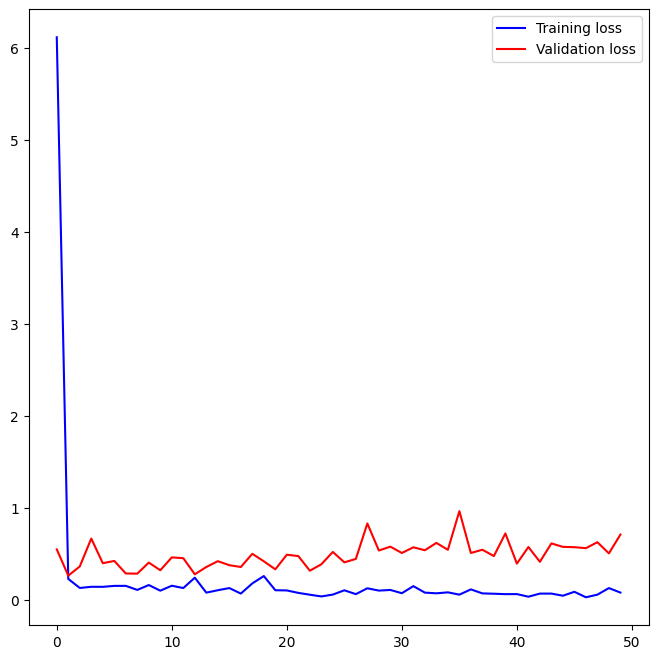

<Figure size 640x480 with 0 Axes>

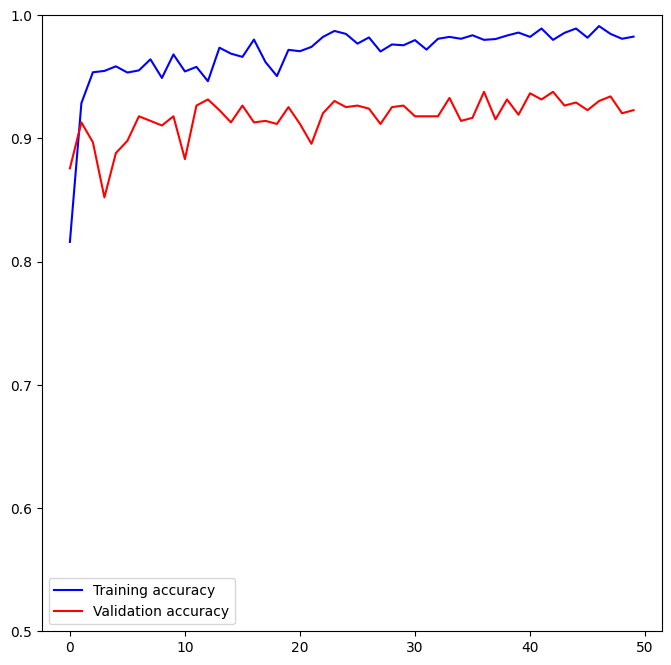

In [10]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

8/8 [==============================] - 3s 50ms/step


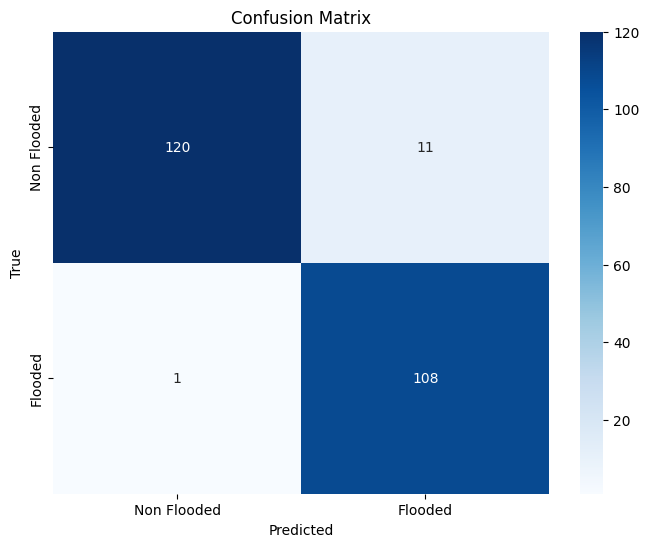

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       131
           1       0.91      0.99      0.95       109

    accuracy                           0.95       240
   macro avg       0.95      0.95      0.95       240
weighted avg       0.95      0.95      0.95       240



In [8]:
test_data_path = os.path.join(data_saved_dir, 'A_preprocessed_data test_images(256, 256).pkl')
test_images, test_labels = load_pickle(test_data_path)

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [9]:
model_saved = r'D:\My Code\Classification\models'
save_pickle(model, os.path.join(model_saved, 'D_InceptionV3 (256X256).pkl'))

INFO:tensorflow:Assets written to: ram://2df4554f-1a5d-4691-b345-9283b890b4a4/assets


INFO:tensorflow:Assets written to: ram://2df4554f-1a5d-4691-b345-9283b890b4a4/assets
